# How can we predict and mitigate customer churn using machine learning techniques?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

In [2]:
original = pd.read_csv("../../data/processed/Compaign_metrics.csv")

## Develop a machine learning model to predict the likelihood of customer churn.

In [3]:
# in data_cleaning.ipynb: Existing customer: 1 & Attrited Customer: 0
# so, for Churn: 1 is No and 0 is Yes
original['Churn'] = original['Attrition_Flag'].apply(lambda x: 'No' if x == 1 else 'Yes')

In [4]:
churn_rate = original['Churn'].value_counts(normalize = True)['Yes'] * 100
print(f"The Churn Rate is quite high at {churn_rate:.2f}%.")

The Churn Rate is quite high at 18.92%.


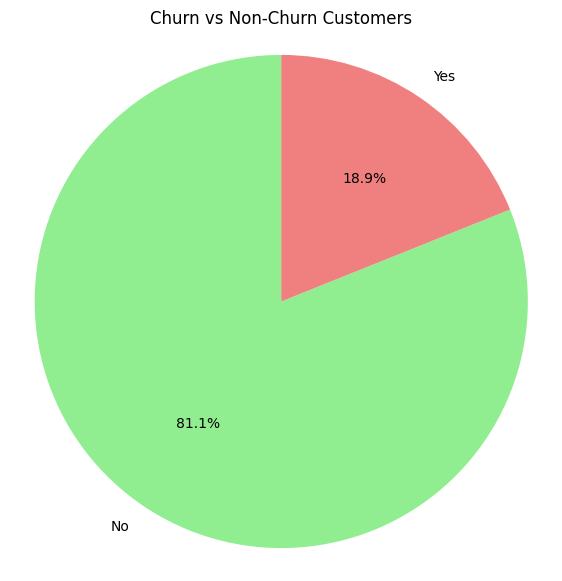

In [5]:
# pie chart
churn_counts = original['Churn'].value_counts()
plt.figure(figsize = (7, 7))
plt.pie(churn_counts, labels = churn_counts.index, autopct='%1.1f%%', startangle = 90, colors = ['lightgreen', 'lightcoral'])
plt.title("Churn vs Non-Churn Customers")
plt.axis('equal')
plt.show()

### Likelihood of Churning for each customer

#### Preparing the data

In [7]:
np.random.seed(3101)

# encoding 'Income_Category', 'Product_Usage', 'Cluster_Labels' and 'Churn' to numerical formats
encoders = {}
for c in ['Gender', 'Income_Category', 'Education_Level', 'Marital_Status', 'Card_Category'
          , 'Churn']:
    le = LabelEncoder()
    original[c] = le.fit_transform(original[c])
    encoders[c] = le

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X = original.drop(columns = ['Churn', 'Attrition_Flag'])
y = original['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

#### Random Forest Classifier

To add Churn_Probability to the data.

In [8]:
model = RandomForestClassifier(random_state = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
churn_probabilities = model.predict_proba(X)[:, 1]

# add likelihood of a customer churning into the dataset
original['Churn_Probability'] = churn_probabilities

#### Testing viability

##### Accuracy and F1 scores

In [9]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.8607
F1 score: 0.5199


##### AUC - ROC 

AUC-ROC score: 0.8780


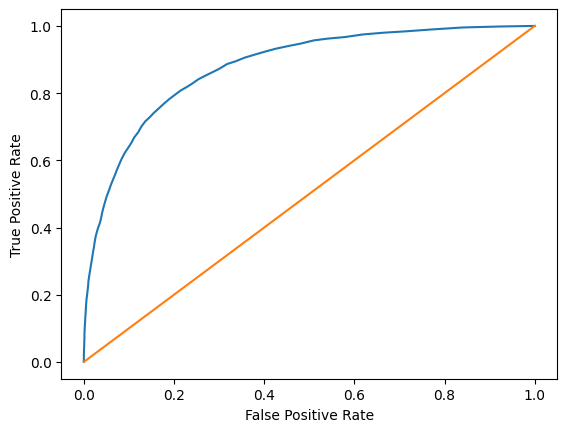

In [10]:
y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC score: {auc:.4f}")

# plotting the AUC-ROC
false_pos_r, true_pos_r, thresholds = roc_curve(y_test, y_prob)
plt.plot(false_pos_r, true_pos_r)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

- Accuracy: Approximately 86% of the predictions are correct. While this is a decent accuracy, in the case of imbalanced datasets, accuracy alone is not sufficient to measure the model’s performance, especially if the data is skewed (in our data, only ~19% of the customers churned).
- F1 Score: The F1 score is much lower, which suggests that the model may be struggling to correctly classify the minority class ("Churn"). The F1 score is the harmonic mean of precision and recall, and a low F1 score indicates that the model has poor precision or recall (or both) for the minority class, even though the accuracy may still appear high.
- AUC-ROC Score: The model has a good ability to distinguish between the two classes. This is often seen as a better metric than accuracy, especially in imbalanced datasets, because it evaluates performance across all classification thresholds (not just the default 0.5).

Given that the AUC-ROC score is higher than the accuracy and F1 score, this suggests that the model might be overpredicting the majority class (customers who did not churn; "No"). However, the model still can separate the two classes fairly well.

Other models like Linear Regression could be tried to attain better scores. However, most models might give similar scores because of the low churning rate (this is good for the bank but not for the model).

### Likelihood of customer churn

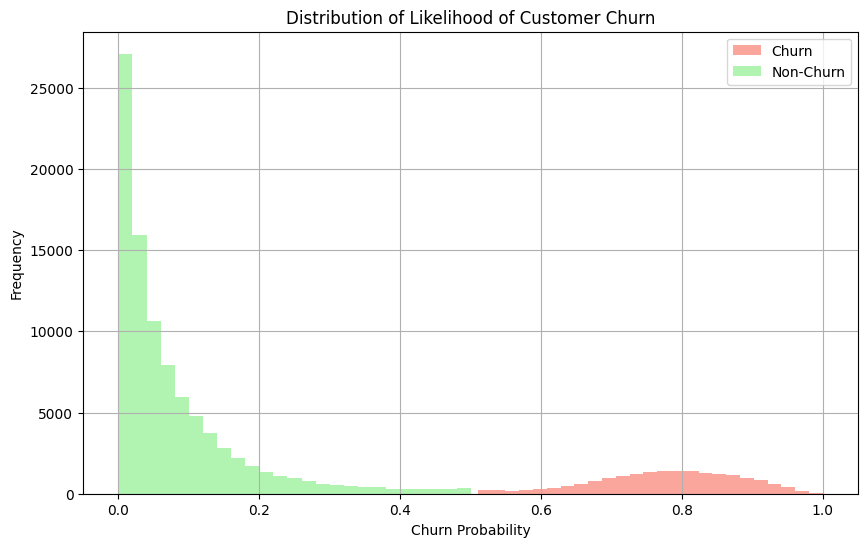

In [11]:
churn = original[original['Churn_Probability'] > 0.5]
not_churn = original[original['Churn_Probability'] <= 0.5]

# distribution
plt.figure(figsize = (10, 6))
plt.hist(churn['Churn_Probability'], bins = 25, alpha = 0.7, label = 'Churn', color = 'salmon')
plt.hist(not_churn['Churn_Probability'], bins = 25, alpha = 0.7, label = 'Non-Churn', color = 'lightgreen')
plt.title('Distribution of Likelihood of Customer Churn')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

The plot shows the distribution of the likelihood that a customer churns. The green bars signify low likelihoods (<=0.5) and the red bars signify high liklihoods (>0.5).
This distribution is to be expected since most of the chustomers did not churn.

### Early Warning System

In [25]:
def calculate_financial_status_averages(df):
    """
    Calculate and print the average Financial_Status for churned and non-churned customers.

    Parameters:
    df (DataFrame): The dataset containing customer data with 'Churn' and 'Financial_Status' columns.

    Returns:
    tuple: A tuple containing the average Financial_Status for churned and non-churned customers.
    """
    churned = df[df['Churn'] == 1]
    non_churned = df[df['Churn'] == 0]

    churned_mean = churned['Financial_Status'].mean()
    non_churned_mean = non_churned['Financial_Status'].mean()

    print("Average Financial_Status for churned customers:", churned_mean)
    print("Average Financial_Status for non-churned customers:", non_churned_mean)

    return churned_mean, non_churned_mean

# Calculate financial status averages
churned_mean, non_churned_mean = calculate_financial_status_averages(original)
# Since churned customers have a lower Financial_Status value on average, it suggests that lower Financial_Status values correlate with a higher churn risk.

def calculate_loyalty_threshold(df):
    """
    Calculate the 25th percentile of the 'Loyalty' column for both churned and non-churned customers.

    Parameters:
    df (DataFrame): The dataset containing customer data with 'Churn' and 'Loyalty' columns.

    Returns:
    tuple: A tuple containing the 25th percentile loyalty values for churned and non-churned customers.
    """
    churned = df[df['Churn'] == 1]
    non_churned = df[df['Churn'] == 0]

    churned_loyalty_25th = churned['Loyalty'].quantile(0.25)
    non_churned_loyalty_25th = non_churned['Loyalty'].quantile(0.25)

    return churned_loyalty_25th, non_churned_loyalty_25th

# Calculate loyalty thresholds
churned_loyalty_25th, non_churned_loyalty_25th = calculate_loyalty_threshold(original) # to find which treshold to set for loyalty

# Defining threshold criteria for high-risk customers
churn_status_threshold = 1         # Let 1 = churned, 0 = non-churned
financial_status_threshold = 4.0     # Threshold for financial status
loyalty_threshold = 3              # Threshold for loyalty

# Apply early warning system criteria
def apply_early_warning_system(df, churn_status_threshold=1, financial_status_threshold=4.0, loyalty_threshold=3):
    """
    Add an 'Alert' column to the dataset based on early warning system criteria to identify high-risk customers.

    Parameters:
    df (DataFrame): The dataset containing customer data with 'Churn', 'Financial_Status', and 'Loyalty' columns.
    churn_status_threshold (int): Threshold value for churn status (1 for churned).
    financial_status_threshold (float): Threshold for financial status to indicate high risk.
    loyalty_threshold (int): Threshold for loyalty score to indicate high risk.

    Returns:
    DataFrame: The original DataFrame with an added 'Alert' column indicating customer risk.
    """
    df['Alert'] = df.apply(
        lambda row: 'High risk of churn - follow up needed' if (
            row['Churn'] >= churn_status_threshold or              # Churned or likely to churn
            row['Financial_Status'] < financial_status_threshold or # Low financial stability
            row['Loyalty'] < loyalty_threshold                     # Low loyalty score
        ) else 'Low risk',
        axis=1
    )
    return df

original = apply_early_warning_system(original)

# Display results
print(original[['CLIENTNUM', 'Churn', 'Financial_Status', 'Loyalty', 'Alert']])

# Count high-risk and low-risk customers
risk_counts = original['Alert'].value_counts()
print("\nCustomer Risk Summary:")
print(risk_counts)  # high risk = 51479, low risk = 58645

Average Financial_Status for churned customers: 4.503167898627244
Average Financial_Status for non-churned customers: 4.499260835479897
        CLIENTNUM  Churn  Financial_Status  Loyalty  \
0       768805383      0                 3        3   
1       818770008      0                 6        3   
2       713982108      0                 3        2   
3       709106358      0                 5        3   
4       713061558      0                 6        2   
...           ...    ...               ...      ...   
110119  739115251      0                 5        6   
110120  531828724      0                 3        6   
110121  916155331      0                 9        7   
110122  447168581      0                 7        6   
110123  474328575      0                 8        2   

                                        Alert  
0       High risk of churn - follow up needed  
1                                    Low risk  
2       High risk of churn - follow up needed  
3          

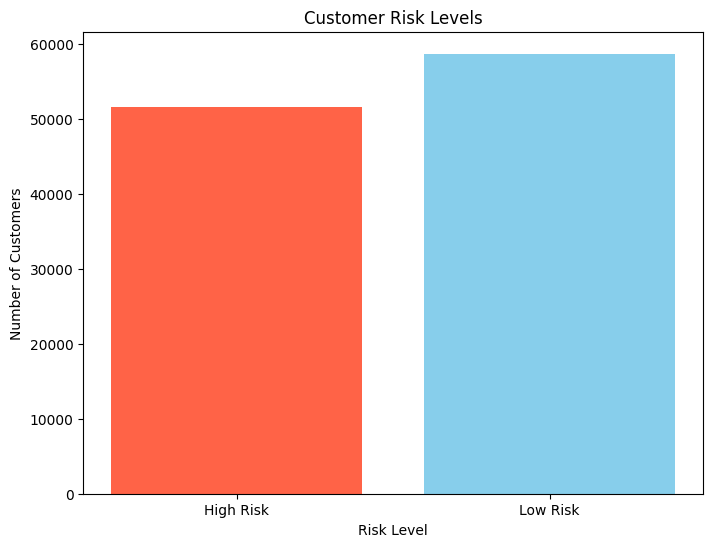

In [29]:
risk_labels = ['High Risk', 'Low Risk']
risk_counts = [51479, 58645]

plt.figure(figsize=(8, 6))
plt.bar(risk_labels, risk_counts, color=['tomato', 'skyblue'])
plt.title('Customer Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

#### Retention Strategies

1. Personalized Communication Targeted Messaging: Use customer data to send tailored emails that acknowledge individual preferences and behaviors. Highlight relevant promotions or services to create a more personalized experience, which can significantly enhance engagement and satisfaction.

2.  Incentives and Rewards Loyalty Programs: Implement a rewards program that encourages continued use of your services. Offering points, discounts, or exclusive benefits can motivate high-risk customers to remain loyal and feel valued.

3. Enhanced Customer Support Dedicated Account Management: Assign dedicated account managers to high-risk customers. This personalized support ensures their concerns are addressed promptly and reinforces the commitment to customer satisfaction, fostering a stronger relationship and trust.

In [20]:
# for API (for customer churn likelihood)
A_BQ3 = original[["CLIENTNUM", "Churn_Probability"]]
A_BQ3.to_csv('../../data/predictions/A_BQ3.csv', index = False)

In [19]:
# for API 
A_BQ3_pt2 = original[['CLIENTNUM', 'Alert']]
A_BQ3_pt2.to_csv('../../data/predictions/A_BQ3_pt2.csv', index = False)